# SPAtial EFficiency metric
_Autor:_    __Jesús Casado__ <br> _Revisión:_ __24/01/2020__

__Introducción__<br>
Se genera el código para aplicar la métrica de rendimiento de un modelo hidrólogico SPAEF [(Koch et al., 2018)](https://www.geosci-model-dev.net/11/1873/2018/). Es una función objetivo que analiza espacialmente el rendimiento del modelo y que emula la lógica detrás del criterio KGE (Kling-Gupta efficiency) [(Gupta et al., 2009)](https://www.sciencedirect.com/science/article/pii/S0022169409004843), utilizado habitualmente para el caudal.

$$SPAEF=1-\sqrt{(\alpha-1)^2+(\beta-1)^2+(\gamma-1)^2}$$
Donde $\alpha$ es el coeficiente de correlación de Pearson, $\beta$ el cociente entre los coeficientes de variación (representativo de la variabilidad espacial), y $\gamma$ es la intersección entre los histogramas normalizados del patrón observado ($K$) y del patrón simulado ($L$):
$$\alpha=\rho(obs,sim)
\;,\;\;
\beta=\frac{\frac{\sigma_{sim}}{\mu_{sim}}}{\frac{\sigma_{obs}}{\mu_{obs}}}
\;,\;\;
\gamma=\frac{\sum_{j=1}^{n}min(K_j,L_j)}{\sum_{j=1}^{n}K_j}$$

Como caso de estudio al que aplicar el código se utilizan los resultados de la simulación de la evapotranspiración en la cuenca alta del río Deva.

<font color='indianred'>__Limitación__: compara el acuerdo entre dos mapas, no entre dos series de mapas. Es decir, hay que obtener un mapa medio representativo de la variable. </font>

__Cosas que arreglar__ <br>

***

__Índice__ <br>
__[0 Configuración](#0-Configuración)__<br>

__[1 Sesgo](#1-Sesgo)__<br>
[1.1 Resultados SCEUA](#1.1-Resultados-SCEUA)<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.style.use('dark_background')
from datetime import datetime, timedelta
from netCDF4 import Dataset
import os
rutaBase = os.getcwd().replace('\\', '/') + '/'
print(rutaBase)

F:/Codigo/GitHub/Calibrar/docs/


In [2]:
os.chdir(rutaBase + '..')
from read_write import read_ascii

## Cargar datos
#### MODIS

In [3]:
rutaMODIS = rutaBase + '../../MODIS/output/ET/'
filename = 'MODIS_ET_500m.nc'

In [4]:
# Cargar netcdf con los datos MODIS
ncRead = Dataset(rutaMODIS + filename, 'r', format='NETCDF4')

# extraer datos en un diccionario
ET = {'Terra': {}, 'Aqua': {}}
for sat, product in zip(['Terra', 'Aqua'], ['MOD16A2', 'MYD16A2']):
    # evapotranspiración
    ET[sat]['ET'] = ncRead[sat][product][::]
    # fechas
    ET[sat]['dates'] = [datetime(1, 1, 1) + timedelta(time) for time in ncRead[sat]['time'][:]]
    # coordenadas
    ET[sat]['X'] = ncRead[sat]['X'][:]
    ET[sat]['Y'] = ncRead[sat]['Y'][:]

ncRead.close()

Voy a utilizar los datos de __Terra__ porque comienzan antes y, por tanto, tienen mayor solape con el periodo de simulación en TETIS.

In [19]:
ET['Terra']['ET'].shape

(863, 48, 49)

#### TETIS

In [7]:
rutaTETIS = 'F:/Proyectos/GESDIVAH/SDM/TETIS/PdE/Actual/Bias/'

In [42]:
# lista de archivos con los resultados
os.chdir(rutaTETIS + '_ASCII/')
files = [file for file in os.listdir() if file[-3:] == 'asc']

# cargar archivos ascii con los resultados de TETIS
for i, file in enumerate(files):
    print('archivo {0:>3} de {1}: {2}'.format(i+1, len(files), file), end='\r')
    # leer archivo ascii
    read_ascii(file)
    if i == 0:
        ETtetis = read_ascii.data
        atrs = read_ascii.attributes
    else:
        ETtetis = np.dstack((ETtetis, read_ascii.data))
# transformar 'ETtetis' para que la primera dimensión sea el tiempo
tmp = np.ones((ETtetis.shape[2], ETtetis.shape[0], ETtetis.shape[1])) * np.nan
for i in range(ETtetis.shape[2]):
    tmp[i,:,:] = ETtetis[:,:,i]
ETtetis = tmp
del tmp

In [43]:
# fechas de cada mapa
datesStr = [file.split('_')[1].split('.')[0][:8] for file in files]
datesTetis = [datetime(int(date[:4]), int(date[4:6]), int(date[6:8])).date() for date in datesStr]

## Mapas medios

In [44]:
dateMin = max(ET['Terra']['dates'][0].date(), datesTetis[0])
dateMax = min(ET['Terra']['dates'][-1].date(), datesTetis[-1])
print('fecha de inicio:\t{0}\nfecha de fin:\t\t{1}'.format(dateMin, dateMax))

fecha de inicio:	2001-01-01
fecha de fin:		2004-09-08


#### Terra

In [45]:
# seleccionar datos de Terra dentro de las fechas de inicio y fin
datesTerra = np.array([d.date() for d in ET['Terra']['dates']])
mask = (datesTerra >= dateMin) & (datesTerra <= dateMax)
datesTerra = datesTerra[mask]
print('nº de fechas: {0}'.format(len(datesTerra)))

# recortar los mapas dentro de las fechas de inicio y fin
ETterra = ET['Terra']['ET'][mask, :, :]
print('dimensiones de la matriz:' + str(ETterra.shape))

nº de fechas: 169
dimensiones de la matriz:(169, 48, 49)


#### TETIS

In [49]:
# seleccionar datos de TETIS dentro de las fechas de inicio y fin
datesTetis = np.array(datesTetis)
mask = (datesTetis >= dateMin) & (datesTetis <= dateMax)
datesTetis = datesTetis[mask]
print('nº de fechas: {0}'.format(len(datesTetis)))

# recortar los mapas dentro de las fechas de inicio y fin
ETtetis = ETtetis[mask, :, :]
print('dimensiones de la matriz:' + str(ETtetis.shape))

nº de fechas: 45
dimensiones de la matriz:(45, 216, 222)


C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


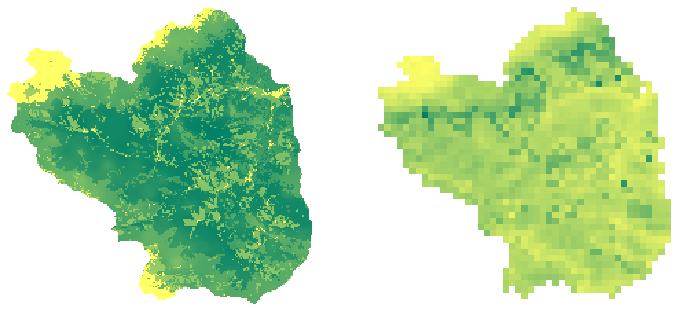

In [68]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

for ax, data in zip(axes, [ETtetis, ETterra]):
    ax.imshow(np.nanmean(data, axis=0), cmap='summer_r')
    ax.axis('off')

1. <font color='steelblue'>Generar mapas medios</font>. Probaría inicialmente con un mapa medio de junio, al igual que hace Koch (2018).
2. <font color='steelblue'>Normalizar mapas</font>. Necesario para comparar dos mapas que puedan tener diferentes magnitudes
3. <font color='steelblue'>Hacer coincidir la resolución espacial</font>. Seguramente sea mejor suavizar el mapa de mayor resolución (TETIS) para acomodarse al de menor resolución (MODIS).
4. <font color='steelblue'>Analizar SPAEF</font>

#### 1 Generar mapas medios
__TETIS__

In [84]:
# evapotranspiración media en junio
mask = np.array([d.month == 6 for d in datesTetis])
print('nº de mapas en junio: {0}'.format(mask.sum()))
meanTETIS = np.nanmean(ETtetis[mask,:,:], axis=0)

nº de mapas en junio: 4


C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


__Terra__

In [86]:
# evapotranspiración media en junio
mask = np.array([d.month == 6 for d in datesTerra])
print('nº de mapas en junio: {0}'.format(mask.sum()))
meanTerra = np.nanmean(ETterra[mask,:,:], axis=0)

nº de mapas en junio: 15


C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


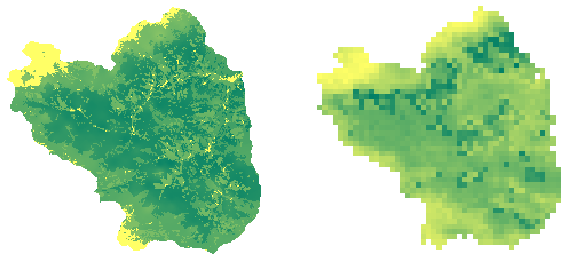

In [88]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for ax, data in zip(axes, [meanTETIS, meanTerra]):
    ax.imshow(data, cmap='summer_r')
    ax.axis('off')